In [66]:
# import libraries 
import pandas as pd

In [67]:
seed = 42
import tensorflow as tf
import numpy as np
np.random.seed(seed)
tf.random.set_seed(seed)

In [68]:
# read the data
df = pd.read_csv("eighthClean.csv",date_parser=['Date'])

# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)

<li>Date</li>
<li>Latitude</li>
<li>Longitude</li>
<li>Time difference(hour)</li>

In [69]:
df.head()

,Date,Latitude,Longitude,Time difference,Time difference in months,Time difference in weeks,Time difference in hours
0,2019-12-03 09:48:08+00:00,51.517431,-0.082458,0 days 17:05:18,0.0,0.0,17.088333
1,2019-12-04 02:53:26+00:00,51.516814,-0.081620,0 days 00:22:31,0.0,0.0,0.375278
2,2019-12-04 03:15:57+00:00,51.513114,-0.086272,0 days 03:20:22,0.0,0.0,3.339444
3,2019-12-04 06:36:19+00:00,51.518060,-0.110683,0 days 06:00:59,0.0,0.0,6.016389
4,2019-12-04 12:37:18+00:00,51.517680,-0.078484,0 days 17:35:50,0.0,0.0,17.597222


In [70]:
df.describe()

,Latitude,Longitude,Time difference in months,Time difference in weeks,Time difference in hours
count,1333.000000,1333.000000,1332.000000,1332.000000,1332.000000
mean,51.514669,-0.086765,0.016056,0.069820,19.632866
std,0.005592,0.012269,0.034227,0.148841,27.384582
min,51.503196,-0.127032,0.000000,0.000000,0.000000
25%,51.511794,-0.094720,0.000000,0.000000,1.075972
50%,51.514457,-0.084701,0.000000,0.000000,8.080000
75%,51.517032,-0.078484,0.032852,0.142857,24.652431
max,51.592365,0.004717,0.262812,1.142857,213.545556


In [71]:
# check for null values
df.isnull().sum()

Date                         0
Latitude                     0
Longitude                    0
Time difference              1
Time difference in months    1
Time difference in weeks     1
Time difference in hours     1
dtype: int64

In [72]:
# df drop time difference in months, Time difference in weeks, Time difference
df = df.drop(['Time difference in months', 'Time difference in weeks', 'Time difference','Date'], axis=1)

In [73]:
df.head()

,Latitude,Longitude,Time difference in hours
0,51.517431,-0.082458,17.088333
1,51.516814,-0.081620,0.375278
2,51.513114,-0.086272,3.339444
3,51.518060,-0.110683,6.016389
4,51.517680,-0.078484,17.597222


In [74]:
# shift the Time difference in hours by 1
df['Time difference in hours'] = df['Time difference in hours'].shift(1)

In [75]:
# fill the null values with mean of the hours difference
df['Time difference in hours'] = df['Time difference in hours'].fillna(df['Time difference in hours'].mean())

In [76]:
import math
df['Time difference in hours'] = df['Time difference in hours'].apply(lambda x: math.ceil(x))

In [77]:
df.head()

,Latitude,Longitude,Time difference in hours
0,51.517431,-0.082458,20
1,51.516814,-0.081620,18
2,51.513114,-0.086272,1
3,51.518060,-0.110683,4
4,51.517680,-0.078484,7


<h1> Create simple baseline model </h1>

In [78]:
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [79]:
import numpy as np
np.set_printoptions(suppress=True) # avoid scientific notation in numpy array so that it is easier to read and understand

In [80]:
def create_dataset(df, time_steps=1):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)])
        y.append(df.iloc[i + time_steps])
    return np.array(X), np.array(y)

In [81]:
# create the dataset
time_steps = 14
X, Y = create_dataset(df, time_steps)

In [82]:
# print the first 1 rows of the dataset
print(X[0:1])
print(Y[0:1])

[[[51.517431 -0.082458 20.      ]
  [51.516814 -0.08162  18.      ]
  [51.513114 -0.086272  1.      ]
  [51.51806  -0.110683  4.      ]
  [51.51768  -0.078484  7.      ]
  [51.516814 -0.08162  18.      ]
  [51.517032 -0.089451 45.      ]
  [51.517032 -0.089451  1.      ]
  [51.513132 -0.09071   5.      ]
  [51.515075 -0.077513 53.      ]
  [51.513051 -0.104001 24.      ]
  [51.516814 -0.08162  47.      ]
  [51.514276 -0.087549 19.      ]
  [51.514151 -0.074958 21.      ]]]
[[51.516814 -0.08162   3.      ]]


In [83]:
# transform Y to 3Dimensional 
Y = Y.reshape(Y.shape[0], 1, Y.shape[1])

In [84]:
print(X.shape)
print(Y.shape)

(1319, 14, 3)
(1319, 1, 3)


In [85]:
# split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [86]:
# create lstm model
import keras
from tensorflow.keras import models
from tensorflow.keras import layers

In [87]:
def build_baseline_model(): #build the model
    model = models.Sequential() # create a sequential model
    model.add(layers.Dense(64, activation = 'relu', input_shape = (time_steps,3))) # add a dense layer with 64 neurons and relu activation function
    model.add(layers.Dense(64, activation = 'relu')) 
    model.add(layers.Dense(3))
    
    model.compile( #compile the model
        optimizer = 'rmsprop', # use rmsprop optimizer
        loss='mse', #loss function
        metrics=['mae'], #metrics
    )
    return model

In [88]:
# model summary
baseline_model = build_baseline_model ()
baseline_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 14, 64)            256       
                                                                 
 dense_12 (Dense)            (None, 14, 64)            4160      
                                                                 
 dense_13 (Dense)            (None, 14, 3)             195       
                                                                 
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [89]:
# fit the model
history = baseline_model.fit(X_train, y_train, epochs=25, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
3/3 [==============================] - 1s 84ms/step - loss: 1316.2356 - mae: 25.5018 - val_loss: 1095.3743 - val_mae: 22.9199
Epoch 2/25
3/3 [==============================] - 0s 17ms/step - loss: 1019.4916 - mae: 22.0165 - val_loss: 909.6539 - val_mae: 20.9214
Epoch 3/25
3/3 [==============================] - 0s 16ms/step - loss: 844.1222 - mae: 20.1502 - val_loss: 752.4709 - val_mae: 19.2502
Epoch 4/25
3/3 [==============================] - 0s 17ms/step - loss: 696.6093 - mae: 18.5681 - val_loss: 635.2304 - val_mae: 17.7193
Epoch 5/25
3/3 [==============================] - 0s 19ms/step - loss: 585.8702 - mae: 17.0997 - val_loss: 536.6690 - val_mae: 16.2369
Epoch 6/25
3/3 [==============================] - 0s 16ms/step - loss: 491.5875 - mae: 15.5583 - val_loss: 455.4789 - val_mae: 14.5550
Epoch 7/25
3/3 [==============================] - 0s 16ms/step - loss: 416.0654 - mae: 13.9275 - val_loss: 393.2299 - val_mae: 13.1182
Epoch 8/25
3/3 [==============================] - 0s

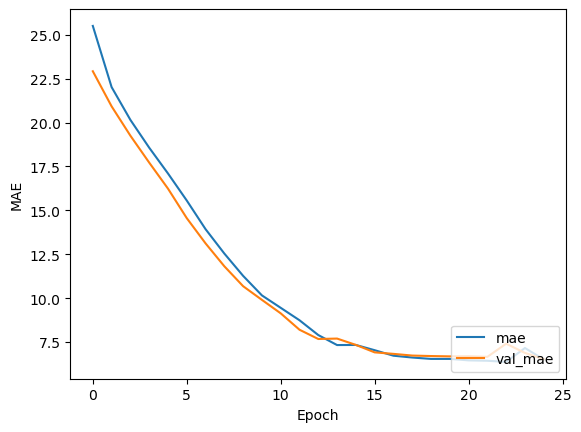

In [90]:
# plot the mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='lower right')
plt.show()


<h1>LSTM</H1>

In [91]:
# Create lstm model
def build_lstm_model(): #build the model
    model = models.Sequential()
    model.add(layers.LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Flatten()),
    model.add(layers.Dense(3))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [92]:
lstm_model = build_lstm_model()
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 512)           1056768   
                                                                 
 flatten_2 (Flatten)         (None, 7168)              0         
                                                                 
 dense_14 (Dense)            (None, 3)                 21507     
                                                                 
Total params: 1,078,275
Trainable params: 1,078,275
Non-trainable params: 0
_________________________________________________________________


In [93]:
# fit the model
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
3/3 [==============================] - 1s 168ms/step - loss: 1063.1431 - mae: 22.9134 - val_loss: 374.4133 - val_mae: 12.8747
Epoch 2/10
3/3 [==============================] - 0s 23ms/step - loss: 323.3997 - mae: 11.9970 - val_loss: 272.9950 - val_mae: 8.2939
Epoch 3/10
3/3 [==============================] - 0s 22ms/step - loss: 253.4367 - mae: 7.5942 - val_loss: 285.9284 - val_mae: 8.2184
Epoch 4/10
3/3 [==============================] - 0s 22ms/step - loss: 261.7102 - mae: 7.6789 - val_loss: 269.7572 - val_mae: 6.7538
Epoch 5/10
3/3 [==============================] - 0s 21ms/step - loss: 248.6966 - mae: 6.6074 - val_loss: 268.8429 - val_mae: 7.2698
Epoch 6/10
3/3 [==============================] - 0s 21ms/step - loss: 251.1310 - mae: 6.9832 - val_loss: 281.8399 - val_mae: 7.0269
Epoch 7/10
3/3 [==============================] - 0s 22ms/step - loss: 254.6844 - mae: 7.0275 - val_loss: 271.3276 - val_mae: 8.0844
Epoch 8/10
3/3 [==============================] - 0s 21ms/step -

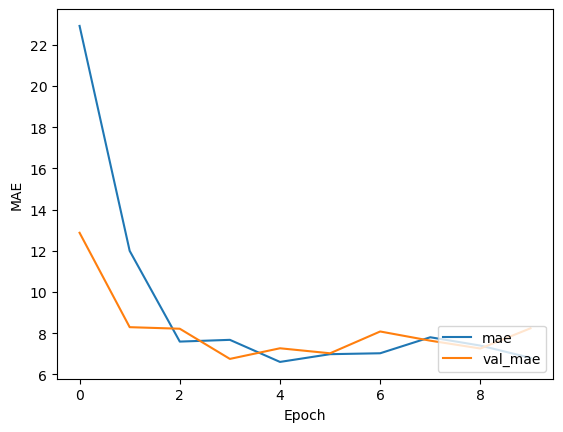

In [94]:
#  plot the mae
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='lower right')
plt.show()

In [95]:
# predict the values
y_pred = lstm_model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [96]:
#  prtint the first predicted value and the actual value
print(y_pred[0])
print(y_test[0])

[51.727394  -1.4350978 29.433216 ]
[[51.517032 -0.089451  7.      ]]
